#  Stock Market Dataset


In this kernel, we will design and train the model we will use in our Dash web app. We will develop a Long Short-Term Memory (LSTM) Neural Network and harness its capability to solve problems in time series. This model will take as input Closing Stock Prices of previous days and predict the next days Stock Prices.

In [1]:
import os
import random

import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

## Pre-Processing

The dataset we use contains a lot of company's Stock Price history, some of which is quite short. We will focus on NASDAQ companies so we filter the company's data to use.

In [2]:
os.chdir('data/Stocks/')

In [3]:
# This function will be used to determine if any value is missing
def has_nan(df):
    return df.isnull().values.any()

In [4]:
# This function will be used to determine if the data for a given company is too sparse
def has_few_data(df):
    if(df.shape[0] < 2000):
        return True
    
    return False

In [5]:
# This function will be used to determine if there is sufficient and complete data about the company stocks.
def use_company_data(df):
    if(has_nan(df)):
        return False
    elif(has_few_data(df)):
        return False
    else:
        return True

In [6]:
# List of NASDAQ Top 100 Companies except Google's data used for evaluation.
nasdaq = ["atvi.us.txt", "adbe.us.txt", "amd.us.txt", "algn.us.txt", "alxn.us.txt", "amzn.us.txt", "amgn.us.txt",
          "aal.us.txt", "adi.us.txt", "aapl.us.txt", "amat.us.txt", "asml.us.txt", "adsk.us.txt", "adp.us.txt",
          "avgo.us.txt", "bidu.us.txt", "biib.us.txt", "bmrn.us.txt", "cdns.us.txt", "celg.us.txt", "cern.us.txt",
          "chkp.us.txt", "chtr.us.txt", "ctrp.us.txt", "ctas.us.txt", "csco.us.txt", "ctxs.us.txt", "cmcsa.us.txt", 
          "cost.us.txt", "csx.us.txt", "ctsh.us.txt", "dltr.us.txt", "ea.us.txt", "ebay.us.txt", "expe.us.txt", 
          "fast.us.txt", "fb.us.txt", "fisv.us.txt", "fox.us.txt", "foxa.us.txt", "gild.us.txt", "goog.us.txt", 
          "has.us.txt", "hsic.us.txt", "ilmn.us.txt", "incy.us.txt", "intc.us.txt", "intu.us.txt", "isrg.us.txt"]

In [7]:
# Aggregate all the companies of interest.
files = []
for file in nasdaq:
    try:
        df = pd.read_csv(file, sep=',')
        if(use_company_data( df )):
            files.append(file)
    except:
        continue

## Processing

We will explore two kinds of data types:
- Closing Stock price variation: percent variation between two consecutinve stock prices. This format is efficient if we want our model to be accurate for companies with a high variance of stock prices (high or low, stable or unstable).
- Raw Closing Stock price.

In [8]:
input_len = 25
output_len = 5

def split_data_variations_in_windows(df):
    """
    Create series of "input_len" Closing prices variation and its coresponding "output_len" price variation.
    """
    LSTM_inputs = []
    LSTM_outputs = []
    for i in range(len(df) - input_len - 1 - output_len):
        # Compute the percent change between a stock price and its previous stock price.
        # Process the model's input sequence.
        tmp_numerator = df[i+1 : (i+input_len+1)].copy()
        tmp_denominator = df[i : (i+input_len)].copy()
        tmp_df = tmp_numerator.values / tmp_denominator.values - 1
        LSTM_inputs.append(np.array(tmp_df))
        # TODO: check if this is correct
        # Process the model's expected output sequence
        tmp_numerator = df[i+input_len+1 : (i+input_len+output_len+1)].copy()
        tmp_denominator = df[i+input_len : (i+input_len+output_len)].copy()        
        tmp_df = tmp_numerator.values / tmp_denominator.values - 1
        LSTM_outputs.append(np.array(tmp_df))
        
    LSTM_inputs = np.array(LSTM_inputs)
    LSTM_outputs = np.array(LSTM_outputs)

    return LSTM_inputs, LSTM_outputs


def split_data_prices_in_windows(df):
    """
    Create series of "input_len" Closing prices and its coresponding  "output_len" price.    
    """
    LSTM_inputs = []
    LSTM_outputs = []    
    for i in range(len(df) - input_len - 1 - output_len):
        # Process the model's input sequence
        tmp_df = df[i : (i+input_len)].copy()
        LSTM_inputs.append(np.array(tmp_df))
        
        # Process the model's expected output sequence
        tmp_df = df[i+input_len : (i+input_len+output_len)].copy()        
        LSTM_outputs.append(np.array(tmp_df))
        
    LSTM_inputs = np.array(LSTM_inputs)
    LSTM_outputs = np.array(LSTM_outputs)
    
    return LSTM_inputs, LSTM_outputs

## Model Design

Let us use the methods written from jeremyjordan.me/nn-learning-rate. One will be used to find the best Learning Rate Range in which to operate and the Second, to perform Stochastic Gradient Descent with Restarts to avoid local minimas.

We will create our model with an Adam Optimizer to accelerate learning. Since this is a regression problem, we will use a Mean Square Error problem.

In [9]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [10]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
        
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [11]:
def LSTM_model(input_shape, output_shape, neurons, dropout):
    x = Input(shape=input_shape)
    hidden = LSTM(2 * neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=False)(hidden)
    hidden = Dropout(dropout)(hidden)
    y = Dense(output_shape, activation='linear')(hidden)
    return Model(inputs=x, outputs=y)

model = LSTM_model((1, input_len), output_len, 8, 0.05)

In [12]:
class LossHistory(Callback):
    def __init__(self):
        self.loss = []
        self.val_loss = []

    def on_batch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('loss'))
        
cb = LossHistory()

In [13]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

### Fine-tuning

Let us firstly look at how an untrained model performes beforehand to have a baseline upon which to improve.

In [14]:
# Load the Google data as the evaluation set.
testing = pd.read_csv('goog.us.txt', sep=',')["Close"]
    
# Process the data
LSTM_inputs, LSTM_outputs = split_data_prices_in_windows(testing)
LSTM_inputs = np.reshape(LSTM_inputs, (LSTM_inputs.shape[0], 1, LSTM_inputs.shape[1]))

# Evaluate
model.evaluate(LSTM_inputs, LSTM_outputs)

885/885 [==============================] - 3s 3ms/step


[519075.4189971751, 519075.4189971751]

Epoch 1/1
885/885 [==============================] - 2s 2ms/step - loss: 515529.2303 - mean_squared_error: 515529.2303


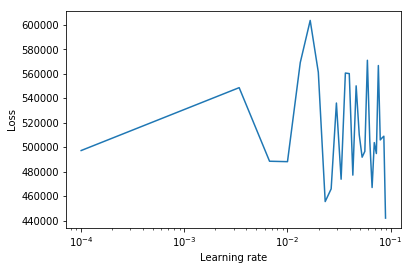

In [15]:
# find learning rate first
epoch_size = 20
batch_size = 256

lr_finder = LRFinder(min_lr=1e-4, 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=3)
model.fit(LSTM_inputs, LSTM_outputs, callbacks=[lr_finder])

lr_finder.plot_loss()

In [16]:
# Create the Learning Rate Scheduler Callback
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length= 3,
                         mult_factor=1.5)

## Training - Stock Price Prediction

Let us now look at the raw stock prices.

In [17]:
file_dups = []

for i in range(25):
    # Randomly select a file (that was approved before hand) and load it.
    file_nb = random.randint(0, len(files)-1)
    if file_nb in file_dups:
        continue
    else:
        file_dups.append(file_nb)
    df = pd.read_csv(files[file_nb], sep=',')["Close"]
    
    # Split the data into train-validation-testing sets (80-20).
    length = df.shape[0]
    df_train = df[:int(length*0.8)]
    df_valid = df[int(length*0.8)+1:]
    
    # Process the data
    LSTM_train_inputs, LSTM_train_outputs = split_data_prices_in_windows(df_train)
    LSTM_valid_inputs, LSTM_valid_outputs = split_data_prices_in_windows(df_valid)

    LSTM_train_inputs = np.reshape(LSTM_train_inputs, (LSTM_train_inputs.shape[0], 1, LSTM_train_inputs.shape[1]))
    LSTM_valid_inputs = np.reshape(LSTM_valid_inputs, (LSTM_valid_inputs.shape[0], 1, LSTM_valid_inputs.shape[1]))
    
    # Since we want our model to be trained on multiple company stocks, we will only train them for a few epochs.
    history = model.fit(LSTM_train_inputs, LSTM_train_outputs, 
                        validation_data = (LSTM_valid_inputs, LSTM_valid_outputs),
                        epochs=5, batch_size=32, verbose=0, callbacks=[cb, schedule])
    
# Save the model.
# serialize model to JSON
model_json = model.to_json()
with open("../../lstm_prices_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../../lstm_prices.h5")

Text(0.5, 0, 'Epoch')

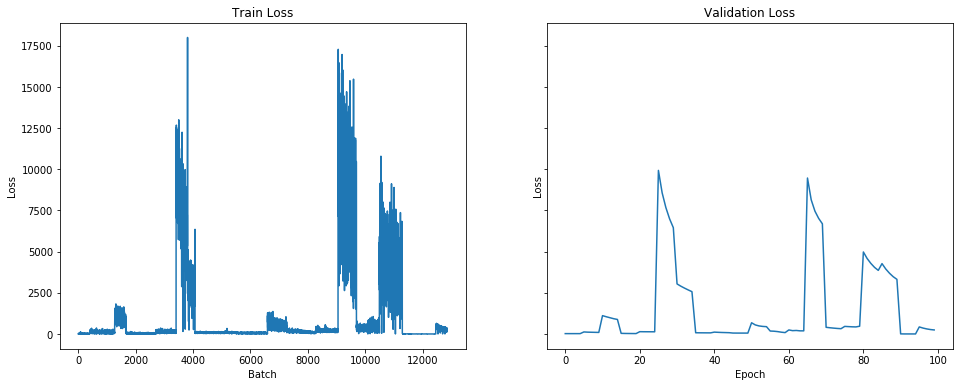

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.plot(cb.loss)
ax1.set_title('Train Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch')
ax2.plot(cb.val_loss)
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

## Evaluation

Let us now  look at how our model performs.

In [ ]:
mse = mean_squared_error(LSTM_outputs, model.predict(LSTM_inputs))
print('The Mean Squared Error is: {}'.format(mse))

The Mean Squared Error is: 504070.1360671373


In [ ]:
# Select a random start date for graphing.
example_nb = random.randint(0, len(LSTM_outputs))

def unsplit_prices(df):
    """
    Function that creates two arrays, one is the original stock prices and the second is 
    an array of the models predictions.
    """
    # Get the original data.
    example_input = df[example_nb : (example_nb+input_len)].copy()
    example_input = np.array(example_input)
    example_output = df[example_nb+input_len : (example_nb+input_len+output_len)].copy()
    example_output = np.array(example_output)
    target = np.concatenate((example_input, example_output))

    # Predict
    tmp = np.reshape(example_input, (1, 1, input_len))
    prediction = model.predict(tmp)
    
    return target, np.concatenate((example_input, prediction[0]))

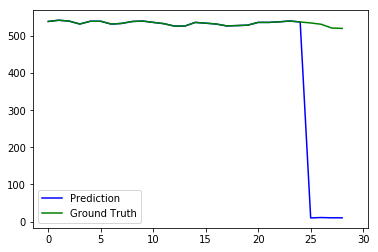

In [ ]:
x = np.linspace(0, input_len+output_len-1, input_len+output_len)
y1, y2 = unsplit_prices(pd.read_csv('goog.us.txt', sep=',')["Close"])

fig, ax = plt.subplots()
prediction, = ax.plot(x, y2, color='b', label='Prediction')
ground_truth, = ax.plot(x, y1, color='g', label='Ground Truth')
ax.legend()

def update(num, x, y1, prediction, y2, ground_truth):
    prediction.set_data(x[:num], y2[:num])
    ground_truth.set_data(x[:num], y1[:num])
    return prediction, ground_truth,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y1, prediction, y2, ground_truth],
                              interval=100, blit=True)

ani.save('../../test_prices.gif', writer="imagemagick")
plt.show()

## Training - Stock Variation Prediction

Since every company is unique in that it operates in a specific field, geographic zone, has different sizes and clients, we need to capture as much of that vairance as possible in our model. We will thus train our model using numerous companies rather than a single one and firstly using the Stock Price Variation.

In [ ]:
# Refresh our model.
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [ ]:
# Process the data
LSTM_inputs, LSTM_outputs = split_data_variations_in_windows(testing)
LSTM_inputs = np.reshape(LSTM_inputs, (LSTM_inputs.shape[0], 1, LSTM_inputs.shape[1]))

# Evaluate
model.evaluate(LSTM_inputs, LSTM_outputs)

885/885 [==============================] - 1s 566us/step


[36.209647240073, 36.209647240073]

Epoch 1/1
885/885 [==============================] - 2s 2ms/step - loss: 6.2381 - mean_squared_error: 6.2381


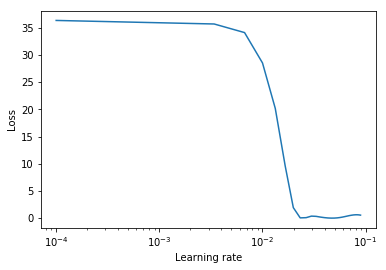

In [ ]:
# find learning rate first
epoch_size = 20
batch_size = 256

lr_finder = LRFinder(min_lr=1e-4, 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=3)
model.fit(LSTM_inputs, LSTM_outputs, callbacks=[lr_finder])

lr_finder.plot_loss()

In [ ]:
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length= 3,
                         mult_factor=1.5)

In [ ]:
file_dups = []

for i in range(25):
    # Randomly select a file (that was approved before hand) and load it.
    file_nb = random.randint(0, len(files)-1)
    if file_nb in file_dups:
        continue
    else:
        file_dups.append(file_nb)
    df = pd.read_csv(files[file_nb], sep=',')["Close"]
    
    # Split the data into train-validation-testing sets (80-20).
    length = df.shape[0]
    df_train = df[:int(length*0.8)]
    df_valid = df[int(length*0.8)+1:]
    
    # Process the data
    LSTM_train_inputs, LSTM_train_outputs = split_data_variations_in_windows(df_train)
    LSTM_valid_inputs, LSTM_valid_outputs = split_data_variations_in_windows(df_valid)

    LSTM_train_inputs = np.reshape(LSTM_train_inputs, (LSTM_train_inputs.shape[0], 1, LSTM_train_inputs.shape[1]))
    LSTM_valid_inputs = np.reshape(LSTM_valid_inputs, (LSTM_valid_inputs.shape[0], 1, LSTM_valid_inputs.shape[1]))
    
    # Since we want our model to be trained on multiple company stocks, we will only train them for a few epochs.
    history = model.fit(LSTM_train_inputs, LSTM_train_outputs, 
                        validation_data = (LSTM_valid_inputs, LSTM_valid_outputs),
                        epochs=10, batch_size=32, verbose=0, callbacks=[cb, schedule])
    
# Save the model.
# serialize model to JSON
model_json = model.to_json()
with open("../../lstm_variation_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../../lstm_variations.h5")

Text(0.5, 0, 'Epoch')

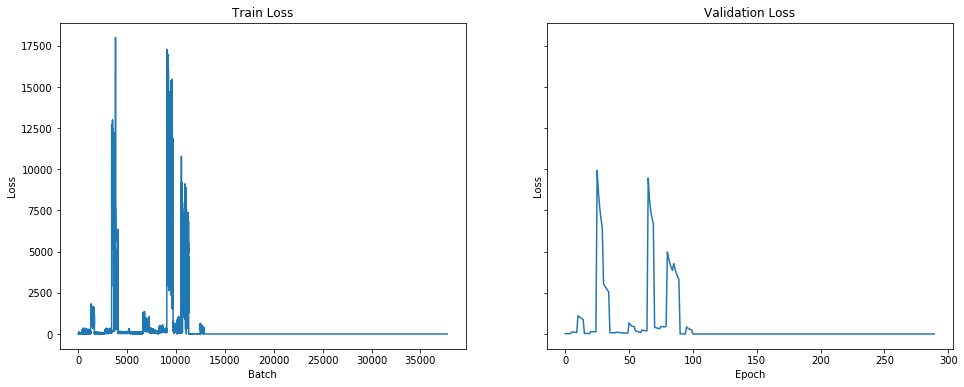

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.plot(cb.loss)
ax1.set_title('Train Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch')
ax2.plot(cb.val_loss)
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

## Evaluation

Let us now  look at how our model performs.

In [ ]:
mse = mean_squared_error(LSTM_outputs, model.predict(LSTM_inputs))
print('The Mean Squared Error is: {}'.format(mse))

The Mean Squared Error is: 0.00019341635015513936


In [ ]:
def unsplit_variations(df):
    """
    Function that creates two arrays, one is the original stock prices and the second is 
    an array of the models predictions turned from a percent variation back to a stock price.
    """
    # Get the original data.
    example_input = df[example_nb : (example_nb+input_len)].copy()
    example_input = np.array(example_input)
    example_output = df[example_nb+input_len : (example_nb+input_len+output_len)].copy()
    example_output = np.array(example_output)
    target = np.concatenate((example_input, example_output))

    # Predict
    tmp = np.reshape(example_input, (1, 1, input_len))
    prediction = model.predict(tmp)

    # Process
    variations = prediction + 1
    predicted = variations
    # Multiply each predicted variation with the previous day's stock price.
    for i in range(variations.shape[1]):
        if i == 0:
            base = example_input[-1]
        else:
            base = predicted[0][i - 1]
        predicted[0][i] = variations[0][i] * base

    return target, np.concatenate((example_input, predicted[0]))

In [ ]:
x = np.linspace(0, input_len+output_len-1, input_len+output_len)
y1, y2 = unsplit_variations(testing)

fig, ax = plt.subplots()
prediction, = ax.plot(x, y2, color='b', label='Prediction')
ground_truth, = ax.plot(x, y1, color='g', label='Ground Truth')
ax.legend()

def update(num, x, y1, prediction, y2, ground_truth):
    prediction.set_data(x[:num], y2[:num])
    ground_truth.set_data(x[:num], y1[:num])
    return prediction, ground_truth,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y1, prediction, y2, ground_truth],
                              interval=100, blit=True)

ani.save('../../test_variations.gif', writer="imagemagick")
plt.show()

## Thoughts

Because Companies Stock are very different from one another, our LSTM tends to perform poorly on the raw stock prices. However, when using the percent change, the LSTM perform better be the data is regularized. Thus the model trained with percent variations could be applied to a wider variety of Companies and still be reliable.